# Solve frozen lake with Q-network

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

Now we will solve the [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment using on-policy neural Q-learning with epsilon-greedy action selection.

In the FrozenLake problem the reinforcement learning agent must navigate a small grid world by moving up, down, left and right.
The task is to move from start position (S) to the goal (G) whithout falling into a hole (H).
The task is made more difficult by the wind that will sometimes send the agent in a random direction regardless of the chosen action.
See an example start state below.

## Q-network

The method we will be using employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) \leftarrow Q(s,a;\theta) + \alpha \delta \ ,
$$

where $\delta = r + \gamma \max_{a'} Q(s',a';\theta) - Q(s,a;\theta)$ is the TD error.

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using squared loss:

$$
L(\theta) = \delta^2 \ ,
$$

with transitions $(s,a,r,s')$ sampled from the environment.

Algorithm:

1. Do a forward pass for current state, $s$, to get predicted Q-values for all actions.
2. Select an action, $a$, with epsilon-greedy strategy and execute it to observe a reward and next state, $r,s'$.
3. Do a forward pass for the next state, $s'$.
4. Set Q-target for action $a$ to $r + \gamma \max_{a'} Q(s',a';\theta)$ and to the Q-values from step 1 for all other actions, making the TD error zero for those outputs.
5. Update network weights with backpropagation.
6. Set $s\leftarrow s'$ and repeat.

In [1]:
!pip install gymnasium
!pip install renderlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 5.6 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym

First we initialize the FrozenLake environment and display an example of the state.

In [3]:
# initialize environment
env = gym.make('FrozenLake-v1', map_name="4x4", render_mode="ansi")

In [4]:
# show initial state
s, _ = env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



Next let's implement the Q-network class.

In [54]:
class QNetwork(nn.Module):
    """Q-network"""

    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(QNetwork, self).__init__()
        # network
        self.out = nn.Linear(n_inputs, n_outputs, bias=False)
        # initialization
        torch.nn.init.uniform_(self.out.weight, 0, 0.01)
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)

    def forward(self, x):
        return self.out(x)

    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))

In [55]:
def one_hot(i, l):
    """One-hot encoder for the states"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [68]:
# train Q-network

num_episodes = 1200
episode_limit = 300
learning_rate = 0.1
gamma = 0.98 # discount rate
val_freq = 100 # validation frequency
epsilon_start = 0.25

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

qnet = QNetwork(n_inputs, n_outputs, learning_rate)

try:
    epsilon = epsilon_start
    rewards, lengths, losses, epsilons = [], [], [], []
    print('start training')
    for i in range(num_episodes):
        # init new episode
        s, ep_reward, ep_loss = env.reset()[0], 0, 0
        for j in range(episode_limit):
            # 1. do foward pass of current state to compute Q-values for all actions
            qnet.optimizer.zero_grad()
            Q = qnet(torch.from_numpy(one_hot([s], n_inputs)).float())
            # 2. select action with epsilon-greedy strategy
            a = Q.argmax().item() if np.random.rand() > epsilon else env.action_space.sample()
            s1, r, done, _, _ = env.step(a)
            # 3. do forward pass for the next state
            with torch.no_grad():
                Q1 = qnet(torch.from_numpy(one_hot([s1], n_inputs)).float())
            # 4. set Q-target
            q_target = Q.clone()
            q_target[0, a] = r + gamma * Q1.max().item() * (not done)
            # 5. update network weights
            loss = qnet.loss(Q, q_target)
            loss.backward()
            qnet.optimizer.step()
            # 6. bookkeeping
            s = s1
            ep_reward += r
            ep_loss += loss.item()
            if done: break
        # bookkeeping
        epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: print('{:5d} mean training reward: {:5.2f}'.format(i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
  100 mean training reward:  0.07
  200 mean training reward:  0.15
  300 mean training reward:  0.18
  400 mean training reward:  0.35
  500 mean training reward:  0.54
  600 mean training reward:  0.70
  700 mean training reward:  0.66
  800 mean training reward:  0.80
  900 mean training reward:  0.76
 1000 mean training reward:  0.82
 1100 mean training reward:  0.75
 1200 mean training reward:  0.83
done


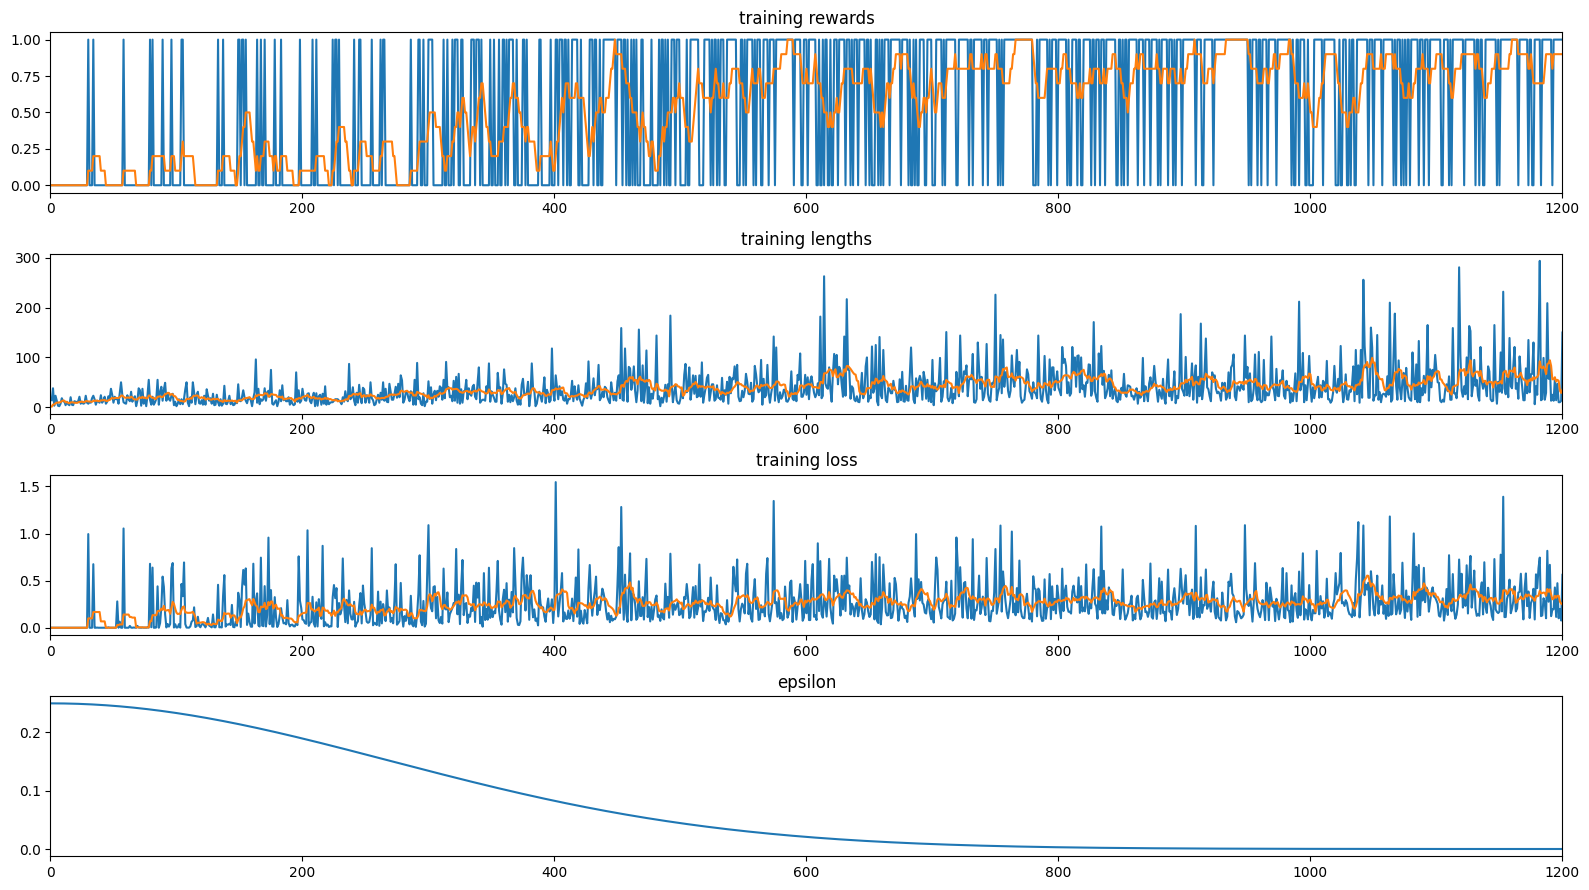

In [69]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(range(1, num_episodes+1), moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()

Now let's review the solution! You can run the cell multiple times to see the behavior of the Q-network.

In [62]:
s, _ = env.reset()
print(env.render())
for _ in range(100):
    a = qnet(torch.from_numpy(one_hot([s], n_inputs)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    print(env.render())
    if done: break


SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (U

## Exercises

Read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent.*

**Answer:**

* `Learning Rate`: Value $0.1$ behaves optimally for the training, otherwise the mean train reward doesn't escape limit $0.2$.
* `Episode Number`: Slightly improves the reward.
* `Network Layers`: Do not help the training process.

### Exercise 2

*How high mean training reward is your solution able to achieve? Do you think it is possible to go even higher? Why/why not?*

**Answer:**

`Maximum`: $\sim 0.84$ mean training reward, limited because of the stochastic effect of the wind on the agen (sent in a random direction)

### Exercise 3

*What role does epsilon play in the code above? Try and change the epsilon start value or the line of code that decreases eplison every update step. How does it affect learning?*

**Answer:**

`Epsilon ε`: $0.25$ chosen as the point where `exploitation` starts improving the policy for greater rewards and decaying slowlier to take benefit from the little `exploration` ability left.


Epsilon (ε) controls the exploration-exploitation trade-off in reinforcement learning using the epsilon-greedy strategy.

1.	Exploration - With probability ε, the agent explores by choosing a random action, which allows it to discover potentially better strategies.
2.	Exploitation - With probability 1 - ε, the agent exploits its current knowledge by selecting the action with the highest predicted Q-value.

This balance is critical for finding optimal policies because:

*	Too much exploration (high ε) means the agent might spend too long taking random actions without improving its policy.

*	Too much exploitation (low ε) risks getting stuck in local optima by favoring actions that seem best based on limited prior knowledge.